### Устанавливаем необходимые библиотеки

In [22]:
# !pip install livelossplot
# !pip install keras_applications --no-deps
# !pip install -U keras-tuner
# ! pip install gdown

### Импорт необходимых библиотек

In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import gdown

import keras

# import keras.backend as K
from tensorflow.keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Input, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import  Objective, BayesianOptimization
from Builder_tools.Unit_tools import MyHyperModel, create_model
from keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback
from keras.applications import VGG16

from Builder_tools.preprocess_func import preprocess_input_ResNet50, preprocess_input_VGG16

2024-02-12 19:13:11.926496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 19:13:11.926560: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 19:13:11.926612: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 19:13:11.931312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 19:13:14.086034: I tensorflow/compiler/

In [2]:
# Настройка лимитов на память GPU (Обучаю на своей машине)
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

2024-02-03 18:58:48.087531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 18:58:48.121629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-03 18:58:48.122115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Загрузка обучающего датасета 

In [2]:
# Загрузка csv файла
df = pd.read_csv('./new_train.csv', index_col = 0)

# Разделим на обучающий и тренировочный датасеты
train_df = df[df['train_test']== 'train'].copy()
test_df = df[df['train_test']== 'test'].copy()

## ТЕСТИРОВАНИЕ МОДЕЛЕЙ

### 1. Модель  VGGFace с архитектурой ResNet50

####  1.1. Зазгузка весов модели VGGFace архитектуры ResNet50

In [60]:
# Скачаем  модель, так как архитектура ResNet50 в реализации keras отличается от архитектуры реализованой в VGGFace
url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
From (redirected): https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO&confirm=t&uuid=948e5b83-1cf3-4dae-b724-b6ffa0b5dff3
To: /media/vision/Локальный диск/Study/Diplom_2/resnet50face.h5
100%|████████████████████████████████████████| 166M/166M [00:19<00:00, 8.34MB/s]


'resnet50face.h5'

In [3]:
# Загружаем модель
vggfaceResNet50_load = load_model("resnet50face.h5")
# Так как модель загрузилась с последними слоями, мы устанавливаем вручную входы и выходы из нее
vggfaceResNet50 = Model(inputs=vggfaceResNet50_load.inputs, outputs=vggfaceResNet50_load.layers[-3].output)

# Удаляем загруженную модель
del vggfaceResNet50_load
# Замораживаем все веса
vggfaceResNet50.trainable = False
vggfaceResNet50.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/7x7_s2 (Conv2D)       (None, 112, 112, 64)         9408      ['input_1[0][0]']             
                                                                                                  
 conv1/7x7_s2/bn (BatchNorm  (None, 112, 112, 64)         256       ['conv1/7x7_s2[0][0]']        
 alization)                                                                                       
                                                                                                  
 activation_1 (Activation)   (None, 112, 112, 64)         0         ['conv1/7x7_s2/bn[0][0]'] 

 activation_8 (Activation)   (None, 55, 55, 64)           0         ['conv2_3_1x1_reduce/bn[0][0]'
                                                                    ]                             
                                                                                                  
 conv2_3_3x3 (Conv2D)        (None, 55, 55, 64)           36864     ['activation_8[0][0]']        
                                                                                                  
 conv2_3_3x3/bn (BatchNorma  (None, 55, 55, 64)           256       ['conv2_3_3x3[0][0]']         
 lization)                                                                                        
                                                                                                  
 activation_9 (Activation)   (None, 55, 55, 64)           0         ['conv2_3_3x3/bn[0][0]']      
                                                                                                  
 conv2_3_1

 conv3_3_1x1_reduce (Conv2D  (None, 28, 28, 128)          65536     ['activation_16[0][0]']       
 )                                                                                                
                                                                                                  
 conv3_3_1x1_reduce/bn (Bat  (None, 28, 28, 128)          512       ['conv3_3_1x1_reduce[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 activation_17 (Activation)  (None, 28, 28, 128)          0         ['conv3_3_1x1_reduce/bn[0][0]'
                                                                    ]                             
                                                                                                  
 conv3_3_3x3 (Conv2D)        (None, 28, 28, 128)          147456    ['activation_17[0][0]']       
          

 add_8 (Add)                 (None, 14, 14, 1024)         0         ['conv4_1_1x1_increase/bn[0][0
                                                                    ]',                           
                                                                     'conv4_1_1x1_proj/bn[0][0]'] 
                                                                                                  
 activation_25 (Activation)  (None, 14, 14, 1024)         0         ['add_8[0][0]']               
                                                                                                  
 conv4_2_1x1_reduce (Conv2D  (None, 14, 14, 256)          262144    ['activation_25[0][0]']       
 )                                                                                                
                                                                                                  
 conv4_2_1x1_reduce/bn (Bat  (None, 14, 14, 256)          1024      ['conv4_2_1x1_reduce[0][0]']  
 chNormali

                                                                                                  
 add_11 (Add)                (None, 14, 14, 1024)         0         ['conv4_4_1x1_increase/bn[0][0
                                                                    ]',                           
                                                                     'activation_31[0][0]']       
                                                                                                  
 activation_34 (Activation)  (None, 14, 14, 1024)         0         ['add_11[0][0]']              
                                                                                                  
 conv4_5_1x1_reduce (Conv2D  (None, 14, 14, 256)          262144    ['activation_34[0][0]']       
 )                                                                                                
                                                                                                  
 conv4_5_1

                                                                                                  
 conv5_1_1x1_increase/bn (B  (None, 7, 7, 2048)           8192      ['conv5_1_1x1_increase[0][0]']
 atchNormalization)                                                                               
                                                                                                  
 conv5_1_1x1_proj/bn (Batch  (None, 7, 7, 2048)           8192      ['conv5_1_1x1_proj[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_14 (Add)                (None, 7, 7, 2048)           0         ['conv5_1_1x1_increase/bn[0][0
                                                                    ]',                           
                                                                     'conv5_1_1x1_proj/bn[0][0]'] 
          

####  1.2. Создание генераторов для обучающих и тестовых данных

In [4]:
BATCH_SIZE = 14
IMAGE_SIZE = 224


# Функция препроцессинга на вход тензор размера (1, H, W, 3) + аугментации
train_generator = ImageDataGenerator(rotation_range=15,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.1,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess_input_ResNet50 # Препроцессинг для ResNet50
                                    ) 

# train generator
train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col='path',
                                                     y_col='category',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='sparse',
                                                     shuffle=True,
                                                     interpolation='nearest'
                                                    )

# validation generator
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input_ResNet50)

val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='path',
                                                 y_col='category',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 shuffle=False,
                                                 interpolation='nearest'
                                                )

Found 45813 validated image filenames belonging to 9 classes.
Found 8100 validated image filenames belonging to 9 classes.


In [5]:
# Проверяем правильность присвоения индексов тренировочный генератор
print(train_data_gen.class_indices)
# Проверяем правильность присвоения индексов тестовый генератор
print(val_data_gen.class_indices)

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7, 'uncertain': 8}
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7, 'uncertain': 8}


#### 1.3. Базовая модель  VGGFace с архитектурой ResNet50 в режиме Feature extracting + BayesianOptimization для полносвязных слоев выхода

In [12]:
# ПОДБОР Гиперпараметров
# Класс MyHyperModel и функция генерации моделей заранее определены 
# from Builder_tools.Unit_tools import HyperModel, create_model
hypermodel = MyHyperModel(base_model=vggfaceResNet50)

tuner = BayesianOptimization(
    hypermodel,
    objective=Objective('val_loss', direction="min"),
    max_trials=20,
    directory='./',
    project_name='best_hyp_par/ResNet50')

tuner.search(train_data_gen,
             epochs=6, validation_data=val_data_gen)

Trial 20 Complete [00h 15m 49s]
val_loss: 1.5523873567581177

Best val_loss So Far: 1.5523873567581177
Total elapsed time: 05h 18m 39s


In [13]:
# Получаем лучшие гиперпарамтры для сети
best_params = tuner.get_best_hyperparameters()
print(f'BEST_HYPER_PARAMS: {best_params[0].values}')

BEST_HYPER_PARAMS: {'units_start': 352, 'activation_start': 'relu', 'num_layers': 1}


#### 1.4. Модель VGGFace с архитектурой ResNet50 с лучшими гиперпараметрами

In [6]:
# Размораживаем все слои базовой модели
vggfaceResNet50.trainable = True

# Оставляем только последние 15 слоев
for i_layer in vggfaceResNet50.layers[:-15]:
    i_layer.trainable = False

model = create_model(
    base_model=vggfaceResNet50,
    start_units=352,
    activation_ch = 'relu', 
    num_layers_start= 1,
    dropout_rate = 0.25
    )


model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1, 1, 2048)        23561152  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 352)               721248    
                                                                 
 batch_normalization (Batch  (None, 352)               1408      
 Normalization)                                                  
                                                                 
 activation_1 (Activation)   (None, 352)               0         
                                                                 
 dropout (Dropout)           (None, 352)               0         
                                                      

In [8]:
# Компиляция модели
checkpoint = ModelCheckpoint('./check_points/ResNet50/VGGFace',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss')

# Будем использовать оптимизатор Адам с динамическим изменением скорости обучения
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=300,
    decay_rate=0.9)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


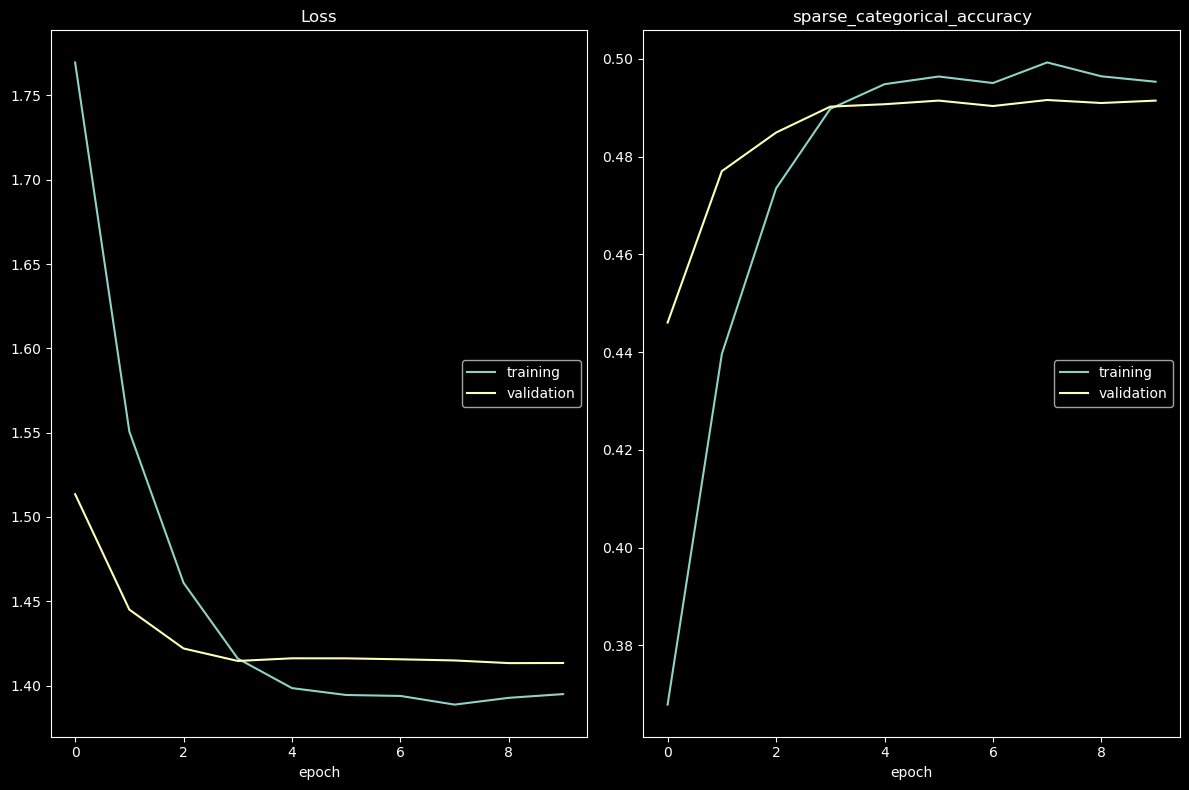

Loss
	training         	 (min:    1.389, max:    1.770, cur:    1.395)
	validation       	 (min:    1.413, max:    1.514, cur:    1.413)
sparse_categorical_accuracy
	training         	 (min:    0.368, max:    0.499, cur:    0.495)
	validation       	 (min:    0.446, max:    0.492, cur:    0.491)
3273/3273 [==============================] - 405s 124ms/step - loss: 1.3950 - sparse_categorical_accuracy: 0.4953 - val_loss: 1.4134 - val_sparse_categorical_accuracy: 0.4915


In [9]:
# Обучение модели
EPOCHS = 10
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[checkpoint, PlotLossesCallback()])

In [10]:
# Загружаем лучшие веса
model.load_weights('./check_points/ResNet50/VGGFace')
# Сохраняем модель 
model.save('./saved_models/VGG_ResNet50')

INFO:tensorflow:Assets written to: ./saved_models/VGG_ResNet50/assets


INFO:tensorflow:Assets written to: ./saved_models/VGG_ResNet50/assets


In [12]:
# Протестируем модель
model.evaluate(val_data_gen)

579/579 [==============================] - 24s 42ms/step - loss: 1.4133 - sparse_categorical_accuracy: 0.4910


[1.4133464097976685, 0.4909876585006714]

### 2. VGGFace на базе VGG16

####  2.1. Зазгузка базовой модели VGGFace архитектуры VGG16

In [13]:
# Загрузим веса модели VGGFace на архитектуре VGG16
url = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'
output = 'rcmalli_vggface_tf_notop_vgg16.h5'
gdown.download(url, output, quiet=False)


Downloading...
From: https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5
To: /media/vision/Локальный диск/Study/Diplom_2/rcmalli_vggface_tf_notop_vgg16.h5
100%|██████████████████████████████████████| 58.9M/58.9M [18:07<00:00, 54.2kB/s]


'rcmalli_vggface_tf_notop_vgg16.h5'

In [13]:
# Инициализируем модель
vggface16_model = VGG16(weights='rcmalli_vggface_tf_notop_vgg16.h5',
     include_top=False,
     input_shape=(224,224,3))

vggface16_model.trainable = False
vggface16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

####  2.2. Создание генераторов для обучающих и тестовых данных

In [24]:
BATCH_SIZE = 14
IMAGE_SIZE = 224


# Функция препроцессинга на вход тензор размера (1, H, W, 3) + аугментации
train_generator = ImageDataGenerator(rotation_range=15,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.1,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess_input_VGG16 # Препроцессинг для VGG16
                                    ) 

# train generator
train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col='path',
                                                     y_col='category',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='sparse',
                                                     shuffle=True,
                                                     interpolation='nearest'
                                                    )

# validation generator
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input_VGG16)

val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='path',
                                                 y_col='category',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 shuffle=False,
                                                 interpolation='nearest'
                                                )

Found 45813 validated image filenames belonging to 9 classes.
Found 8100 validated image filenames belonging to 9 classes.


In [15]:
# Проверяем правильность присвоения индексов тренировочный генератор
print(train_data_gen.class_indices)
# Проверяем правильность присвоения индексов тестовый генератор
print(val_data_gen.class_indices)

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7, 'uncertain': 8}
{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7, 'uncertain': 8}


#### 2.3. Базовая модель  VGGFace с архитектурой VGG16 в режиме Feature extracting + BayesianOptimization для полносвязных слоев выхода

In [24]:
# ПОДБОР Гиперпараметров
hypermodel = MyHyperModel(base_model=vggface16_model)

tuner = BayesianOptimization(
    hypermodel,
    objective=Objective('val_loss', direction="min"),
    max_trials=20,
    directory='./',
    project_name='best_hyp_par/VGG16')

tuner.search(train_data_gen,
             epochs=6, validation_data=val_data_gen)

Trial 20 Complete [00h 21m 17s]
val_loss: 1.597074270248413

Best val_loss So Far: 1.5425471067428589
Total elapsed time: 07h 05m 02s


In [25]:
# Получаем лучшие гиперпарамтры для сети
best_params = tuner.get_best_hyperparameters()
print(f'BEST_HYPER_PARAMS: {best_params[0].values}')

BEST_HYPER_PARAMS: {'units_start': 288, 'activation_start': 'relu', 'num_layers': 2}


In [26]:
vggface16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 2.4. Модель VGGFace с архитектурой VGG16 с лучшими гиперпараметрами

In [25]:
# Размораживаем все слои базовой модели
vggface16_model.trainable = True

# Оставляем только последние 4 слоя
for i_layer in vggface16_model.layers[:-4]:
    i_layer.trainable = False

model = create_model(
    base_model=vggface16_model,
    start_units=288,
    activation_ch = 'relu', 
    num_layers_start= 2,
    dropout_rate = 0.25
    )

model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_15 (Dense)            (None, 288)               7225632   
                                                                 
 batch_normalization_11 (Ba  (None, 288)               1152      
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 288)               0         
                                                                 
 dropout_11 (Dropout)        (None, 288)               0         
                                                      

In [26]:
# Компиляция модели
checkpoint = ModelCheckpoint('./check_points/VGG16/VGGFace',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss')

# Будем использовать оптимизатор Адам с динамическим изменением скорости обучения
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=450,
    decay_rate=0.9)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


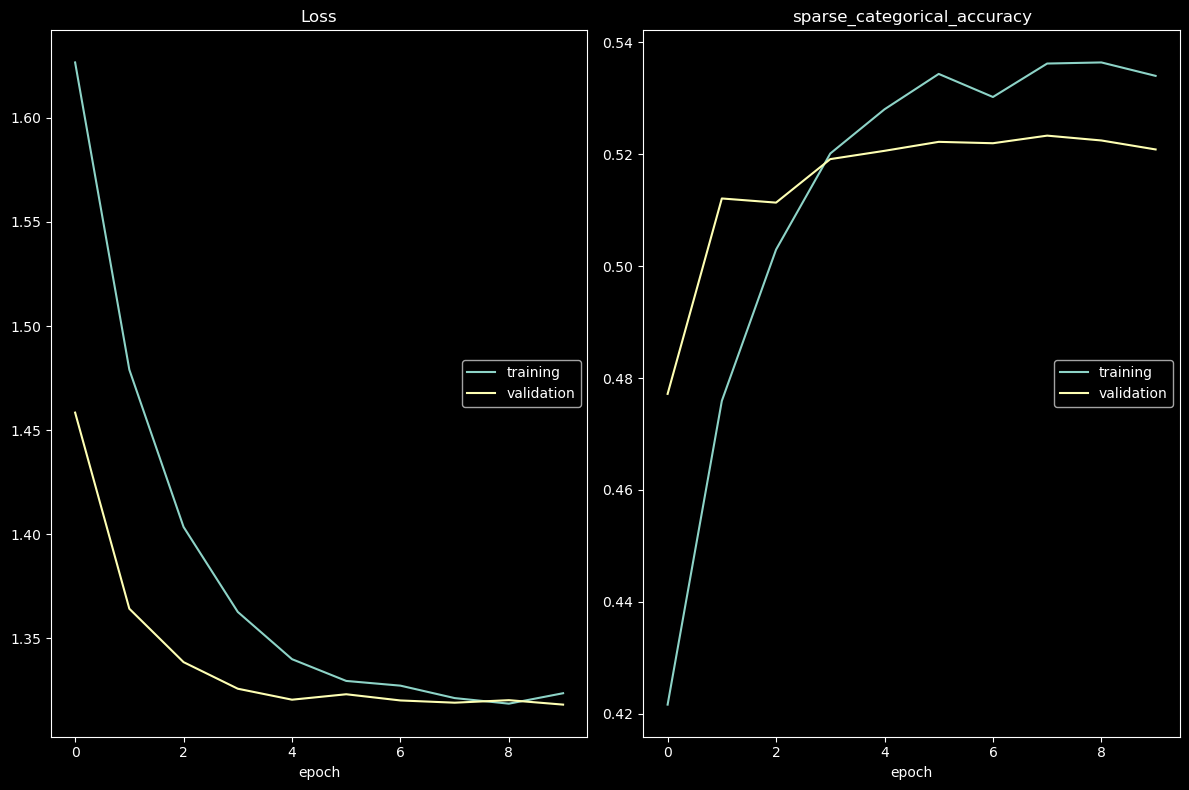

Loss
	training         	 (min:    1.319, max:    1.627, cur:    1.324)
	validation       	 (min:    1.318, max:    1.458, cur:    1.318)
sparse_categorical_accuracy
	training         	 (min:    0.422, max:    0.536, cur:    0.534)
	validation       	 (min:    0.477, max:    0.523, cur:    0.521)
3273/3273 [==============================] - 426s 130ms/step - loss: 1.3236 - sparse_categorical_accuracy: 0.5340 - val_loss: 1.3181 - val_sparse_categorical_accuracy: 0.5209


In [27]:
# Обучение модели
EPOCHS = 10
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[checkpoint, PlotLossesCallback()])

In [32]:
# Загружаем лучшие веса
model.load_weights('./check_points/VGG16/VGGFace')
# Сохраняем модель 
model.save('./saved_models/VGG16')

INFO:tensorflow:Assets written to: ./saved_models/VGG16/assets


INFO:tensorflow:Assets written to: ./saved_models/VGG16/assets


In [30]:
# Протестируем модель
model.evaluate(val_data_gen)

579/579 [==============================] - 37s 63ms/step - loss: 1.3181 - sparse_categorical_accuracy: 0.5209


[1.3181049823760986, 0.5208641886711121]